<a href="https://colab.research.google.com/github/komazawa-deep-learning/komazawa-deep-learning.github.io/blob/master/notebooks/2020_0515komazawa_step_by_step_CNN_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ステップ・バイ・ステップで画像認識の基礎

<font color="teal" size="+3"><strong>PyTorch 編</strong></font>

- Date: 2020-0320
- Author: Shin Asakawa <asakawa@ieee.org>
- Filename: 2020-0515komazawa_step-by-step-CNN-PyTorch.ipynb
<!--- note: Original がどこかにあるはずなのだが，忘れた。見つからない 2020-0513-->

In [0]:
import numpy as np
import PIL
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torchvision
print(torch.__version__, torchvision.__version__)

1.5.0+cu101 0.6.0+cu101


In [0]:
#help(torchvision.models._utils)
#help(torchvision.models.alexnet)
alex = torchvision.models.alexnet(pretrained=True)

In [0]:
import IPython.display
filename="https://miro.medium.com/max/2812/1*bD_DMBtKwveuzIkQTwjKQQ.png"
IPython.display.Image(url=filename)
# from https://towardsdatascience.com/the-w3h-of-alexnet-vggnet-resnet-and-inception-7baaaecccc96

In [0]:
#filename="https://miro.medium.com/max/3684/1*vXBvV_Unz3JAxytc5iSeoQ.png"
#IPython.display.Image(url=filename)

In [0]:
#help(alex)
print(alex)

- 下から上に昇って見ていくと Linear は通常の全結合数であるので in_features=4096 out_features=100 だから，4096 ニューロンを 1000 ニューロンに変換している
- その上は 4096 から 4096 に変換
- 次の (avgpool) のところで出力サイズが (6,6) になっているので penultimate 層では x=6, y=6, チャンネル数（特徴数）= 256 である。
したがって $256\times 6 \times 6 = 9126$ となる。ただし原著論文では平均プーリングではなく最大値プーリングである。

np.sqrt(9216 / 256)

In [0]:
import torchsummary

In [0]:
torchsummary.summary(alex,input_size=(3,224,224))

In [0]:
!pip install torchviz

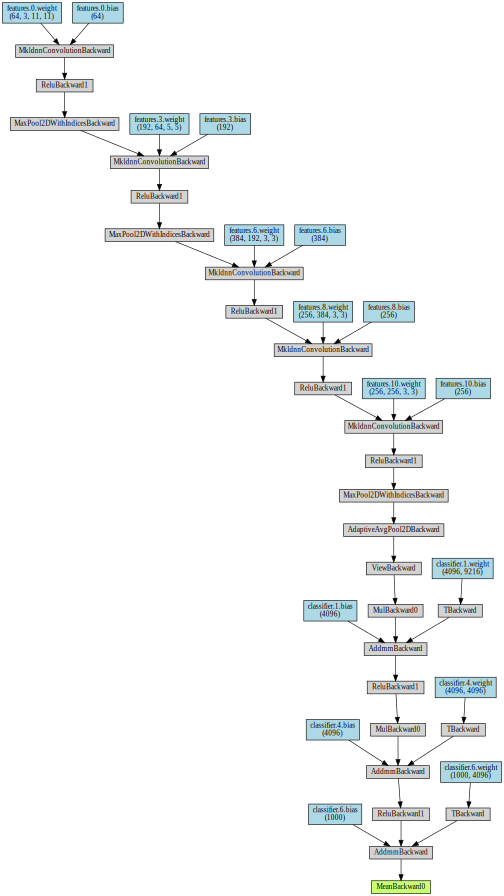

In [10]:
import torchviz

#help(torchviz.make_dot)
x = torch.rand([1,3,255,255])
y = alex.forward(x)
torchviz.make_dot(y.mean(), params=dict(alex.named_parameters()))

In [0]:
import random
import torch.nn as nn

In [0]:
random.seed(1)
torch.manual_seed(1)
gpu = False
alex.cpu()
torch.no_grad()
alex.eval()

In [0]:
from google.colab import files
uploaded = files.upload()

In [0]:
!wget https://blog.counselor.or.jp/wp-content/uploads/2019/06/image001-20.jpg
!mv image001-20.jpg cat.jpg


In [0]:
jpg_file = 'cat.jpg'
#IPython.display.Image(jpg_file)
plt.figure(figsize=(10,8))
plt.axis(False)
plt.imshow(plt.imread(jpg_file))

In [0]:
img = Image.open(jpg_file)

In [0]:
from torchvision import transforms

In [0]:
class BaseTransform():
    """
    画像のサイズをリサイズし、色を標準化する。

    Attributes
    ----------
    sizes : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, sizes, mean, std):
        self.base_transform = transforms.Compose([
            transforms.Resize(sizes),  # 短い辺の長さがresizeの大きさになる
            transforms.CenterCrop(sizes),  # 画像中央をresize × resizeで切り取り
            transforms.ToTensor(),  # Torchテンソルに変換
            transforms.Normalize(mean, std)  # 色情報の標準化
        ])

    def __call__(self, img):
        return self.base_transform(img)

In [0]:
# 3. 画像の前処理と処理済み画像の表示
resize = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
transform = BaseTransform(resize, mean, std)
img_transformed = transform(img)  # torch.Size([3, 224, 224])


In [0]:
#IPython.display.Image(img_transformed.numpy())
type(img_transformed)
img_transformed.size()

In [0]:
a = img_transformed.numpy().transpose((1,2,0))
a = np.clip(a, 0, 1)
plt.axis(False)
plt.imshow(a)

In [0]:
#IPython.display.display(PIL.Image.fromarray(a.transpose(2,0,1)))
#IPython.display.display(a.transpose((2,0,1)))
#from ipython_display import imshow
#imshow(a)
#a.transpose((2,0,1)).shape
#a.shape
#IPython.display.display(IPython.display.Image(data=a))  # ValueError: ndarray is not C-contiguous
#IPython.display.display(a)  # nG
#IPython.display.display(PIL.Image.fromarray(a))

In [0]:
plt.axis(False)
plt.imshow(img)

In [0]:
# 前処理の後、バッチサイズの次元を追加する
transform = BaseTransform(resize, mean, std)  # 前処理クラス作成
img_transformed = transform(img)  # torch.Size([3, 224, 224])
inputs = img_transformed.unsqueeze_(0)  # torch.Size([1, 3, 224, 224])

In [0]:
# モデルに入力し、モデル出力をラベルに変換する
out = alex(inputs)  # torch.Size([1, 1000])

In [0]:
out.detach().numpy().argmax()

In [0]:
import json
!wget https://gist.githubusercontent.com/PonDad/4dcb4b242b9358e524b4ddecbee385e9/raw/dda9454f74aa4fafee991ca8b848c9ab6ae0e732/imagenet_class_index.json

# ImageNet のラベル一覧の読み込み
with open('imagenet_class_index.json') as f:
    data = json.load(f)
    class_names = np.array([row['ja'] for row in data])

In [0]:
# ILSVRCのラベル情報をロードし辞意書型変数を生成します
import json
ILSVRC_class_index = json.load(open('imagenet_class_index.json', 'r'))
#print(ILSVRC_class_index)
len(ILSVRC_class_index)
ILSVRC_class_index[285]

In [0]:
test_img = np.random.random((224,224,3))
#test_img = PIL.Image.fromarray(test_img)
#plt.imshow(test_img)
#img_transformed2 = transform(test_img)
#inputs = img_transformed.unsqueeze_(0)
inputs = torch.from_numpy(test_img).unsqueeze_(0)

In [0]:
#inputs.size()
#out = alex.forward(inputs)
a = torch.rand([1,3,224,224])
out = alex.forward(a)
#alex.forward(torch.from_numpy(np.random.random((1,224,224,3))))

In [0]:
ILSVRC_class_index[out.detach().numpy().argmax()]

In [0]:
!wget https://blog.counselor.or.jp/wp-content/uploads/2019/06/image001-20.jpg
!mv image001-20.jpg cat.jpg


In [0]:
jpg_file = 'cat.jpg'

#IPython.display.Image(jpg_file)
img = Image.open(jpg_file)
img_transformed = transform(img)  # torch.Size([3, 224, 224])
inputs = img_transformed.unsqueeze_(0)  # torch.Size([1, 3, 224, 224])
out = alex(inputs)  # torch.Size([1, 1000])

In [0]:
ILSVRC_class_index[out.detach().numpy().argmax()]